# Changelog
- add evaluation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['csrnet-pytorch-parta-90-120-run-two', 'shanghaitech-with-people-density-map']


In [2]:
print(os.listdir("../input/csrnet-pytorch-parta-90-120-run-two/"))

['__output__.json', 'custom.css', '__results__.html', '__notebook__.ipynb', 'task_two_checkpoint.pth.tar', 'task_two_model_best.pth.tar']


In [3]:
print(os.listdir("../input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech"))

['part_A', 'part_B']


In [4]:
DATA_PATH = "../input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/"
TEST_DATA_PATH = "../input/shanghaitech-with-people-density-map/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/"

In [5]:
# PRETRAIN_BASED = "../input/csrnet-pytorch-parta-30-60-run-two/"
# print(os.listdir(PRETRAIN_BASED))

In [6]:
TASK_ID = "task_two_"

In [7]:
PRETRAIN_MODEL_BASE = "../input/csrnet-pytorch-parta-90-120-run-two/"
print(os.listdir(PRETRAIN_MODEL_BASE))
PRETRAINED_MODEL = os.path.join(PRETRAIN_MODEL_BASE, TASK_ID+"checkpoint.pth.tar")

['__output__.json', 'custom.css', '__results__.html', '__notebook__.ipynb', 'task_two_checkpoint.pth.tar', 'task_two_model_best.pth.tar']


In [8]:
BEST_PRETRAINED_MODEL = os.path.join(PRETRAIN_MODEL_BASE, TASK_ID+"model_best.pth.tar")

In [9]:
assert os.path.isfile(PRETRAINED_MODEL) == True

In [10]:
print(os.listdir(DATA_PATH))

['images', 'ground-truth-h5', 'ground-truth']


# Let's import thing first

These thing is on separate file <br> 
but since Kaggle only give 1 notebook per kernel, we put all here

In [11]:
import h5py
import torch
import shutil

def save_net(fname, net):
    with h5py.File(fname, 'w') as h5f:
        for k, v in net.state_dict().items():
            h5f.create_dataset(k, data=v.cpu().numpy())
def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():        
            param = torch.from_numpy(np.asarray(h5f[k]))         
            v.copy_(param)
            
def save_checkpoint(state, is_best,task_id, filename='checkpoint.pth.tar'):
    torch.save(state, task_id+filename)
    if is_best:
        shutil.copyfile(task_id+filename, task_id+'model_best.pth.tar')            

In [12]:
import torch.nn as nn
import torch
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(list(self.frontend.state_dict().items()))):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)                

In [13]:
"""
contain dummy args with config
helpfull for copy paste Kaggle
"""
import argparse


def make_args(train_json= "", test_json="", pre="", gpu="0", task="task_one_"):
    """
    these arg does not have any required commandline arg (all with default value)
    :param train_json:
    :param test_json:
    :param pre:
    :param gpu:
    :param task:
    :return:
    """
    parser = argparse.ArgumentParser(description='PyTorch CSRNet')

    args = parser.parse_args()
    args.gpu = gpu
    args.task = task
    args.pre = None
    return args


class Meow():
    def __init__(self):
        pass


def make_meow_args(gpu="0", task="task_one_"):
    args = Meow()
    args.gpu = gpu
    args.task = task
    args.pre = None
    return args

In [14]:
import os
import glob
from sklearn.model_selection import train_test_split
import json
"""
create a list of file (full directory)
"""

def create_training_image_list(data_path):
    """
    create a list of absolutely path of jpg file
    :param data_path: must contain subfolder "images" with *.jpg  (example ShanghaiTech/part_A/train_data/)
    :return:
    """
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    return image_path_list


def get_train_val_list(data_path):
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    train, val = train_test_split(image_path_list, test_size=0.1)

    print("train size ", len(train))
    print("val size ", len(val))
    return train, val

In [15]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import cv2

def load_data(img_path,train = True):
    gt_path = img_path.replace('.jpg','.h5').replace('images','ground-truth-h5')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path, 'r')
    target = np.asarray(gt_file['density'])

    target = cv2.resize(target,(int(target.shape[1]/8), int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    return img,target

In [16]:
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as F


class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None,  train=False, seen=0, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        if train:
            root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.seen = seen
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)
        
        #img = 255.0 * F.to_tensor(img)
        
        #img[0,:,:]=img[0,:,:]-92.8207477031
        #img[1,:,:]=img[1,:,:]-95.2757037428
        #img[2,:,:]=img[2,:,:]-104.877445883


        
        
        if self.transform is not None:
            img = self.transform(img)
        return img,target

# done import thing, let's go to training code


In [17]:
import sys
import os

import warnings

# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time

"""
A dublicate of train.py 
However it does not need commandline arg
"""



def main():
    global args, best_prec1
    args = make_meow_args(task=TASK_ID)


    best_prec1 = 1e6

    args.original_lr = 1e-7
    args.lr = 1e-7
    args.batch_size = 1
    args.momentum = 0.95
    args.decay = 5 * 1e-4
    args.start_epoch = 0
    args.epochs = 120
    args.steps = [-1, 1, 100, 150]
    args.scales = [1, 1, 1, 1]
    args.workers = 4
    args.seed = time.time()
    args.print_freq = 30
    args.pre = PRETRAINED_MODEL

    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    torch.cuda.manual_seed(args.seed)

    train_list, val_list = get_train_val_list(DATA_PATH)

    model = CSRNet()

    model = model.cuda()

    criterion = nn.MSELoss(size_average=False).cuda()

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.decay)

    if args.pre:
        if os.path.isfile(args.pre):
            print("=> loading checkpoint '{}'".format(args.pre))
            checkpoint = torch.load(args.pre)
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.pre, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.pre))

#     for epoch in range(args.start_epoch, args.epochs):
#         adjust_learning_rate(optimizer, epoch)

#         train(train_list, model, criterion, optimizer, epoch)
#         prec1 = validate(val_list, model, criterion)

#         is_best = prec1 < best_prec1
#         best_prec1 = min(prec1, best_prec1)
#         print(' * best MAE {mae:.3f} '
#               .format(mae=best_prec1))
#         save_checkpoint({
#             'epoch': epoch + 1,
#             'arch': args.pre,
#             'state_dict': model.state_dict(),
#             'best_prec1': best_prec1,
#             'optimizer': optimizer.state_dict(),
#         }, is_best, args.task)


def train(train_list, model, criterion, optimizer, epoch):
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()

    train_loader = torch.utils.data.DataLoader(
        ListDataset(train_list,
                            shuffle=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225]),
                            ]),
                            train=True,
                            seen=model.seen,
                            batch_size=args.batch_size,
                            num_workers=args.workers),
        batch_size=args.batch_size)
    print('epoch %d, processed %d samples, lr %.10f' % (epoch, epoch * len(train_loader.dataset), args.lr))

    model.train()
    end = time.time()

    for i, (img, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        img = img.cuda()
        img = Variable(img)
        output = model(img)

        target = target.type(torch.FloatTensor).unsqueeze(0).cuda()
        target = Variable(target)

        loss = criterion(output, target)

        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                .format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))


def validate(val_list, model, criterion):
    print('begin test')
    test_loader = torch.utils.data.DataLoader(
        ListDataset(val_list,
                            shuffle=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                            std=[0.229, 0.224, 0.225]),
                            ]), train=False),
        batch_size=args.batch_size)

    model.eval()

    mae = 0
    mse = 0

    for i, (img, target) in enumerate(test_loader):
        img = img.cuda()
        img = Variable(img)
        output = model(img)

        mae += abs(output.data.sum() - target.sum().type(torch.FloatTensor).cuda())
        mse += (output.data.sum() - target.sum().type(torch.FloatTensor).cuda())*(output.data.sum() - target.sum().type(torch.FloatTensor).cuda())
    mae = mae / len(test_loader)
    mse = mse / len(test_loader)
    mse = torch.sqrt(mse)
    
    print(' * MAE {mae:.3f} '
          .format(mae=mae))
    print(' * MSE {mse:.3f} '
          .format(mse=mse))

    return mae


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""

    args.lr = args.original_lr

    for i in range(len(args.steps)):

        scale = args.scales[i] if i < len(args.scales) else 1

        if epoch >= args.steps[i]:
            args.lr = args.lr * scale
            if epoch == args.steps[i]:
                break
        else:
            break
    for param_group in optimizer.param_groups:
        param_group['lr'] = args.lr


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


if __name__ == '__main__':
    main()

train size  270
val size  30


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 127250474.36it/s]
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


=> loading checkpoint '../input/csrnet-pytorch-parta-90-120-run-two/task_two_checkpoint.pth.tar'
=> loaded checkpoint '../input/csrnet-pytorch-parta-90-120-run-two/task_two_checkpoint.pth.tar' (epoch 120)


# Evaluate

In [18]:
test_image_list = create_training_image_list(TEST_DATA_PATH)

In [19]:
best_checkpoint = torch.load(PRETRAINED_MODEL)
model = CSRNet()

model = model.cuda()

criterion = nn.MSELoss(size_average=False).cuda()

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.decay)
model.load_state_dict(best_checkpoint['state_dict'])
optimizer.load_state_dict(best_checkpoint['optimizer'])

In [20]:
test_result = validate(test_image_list, model, criterion)


begin test
 * MAE 72.009 
 * MSE 105.431 


# Evaluate best

In [21]:
best_checkpoint = torch.load(BEST_PRETRAINED_MODEL)
model = CSRNet()

model = model.cuda()

criterion = nn.MSELoss(size_average=False).cuda()

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.decay)
model.load_state_dict(best_checkpoint['state_dict'])
optimizer.load_state_dict(best_checkpoint['optimizer'])

In [22]:
test_result = validate(test_image_list, model, criterion)


begin test
 * MAE 70.603 
 * MSE 104.828 


# Visualize

In [23]:
import glob
import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import os
import numpy as np


def save_density_map(density_map, name):
    plt.figure(dpi=600)
    plt.axis('off')
    plt.margins(0, 0)
    plt.imshow(density_map, cmap=CM.jet)
    plt.savefig(name, dpi=600, bbox_inches='tight', pad_inches=0)

In [24]:
best_checkpoint = torch.load(BEST_PRETRAINED_MODEL)
model = CSRNet()

model = model.cuda()

criterion = nn.MSELoss(size_average=False).cuda()

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.decay)
model.load_state_dict(best_checkpoint['state_dict'])
optimizer.load_state_dict(best_checkpoint['optimizer'])

In [25]:
test_loader = torch.utils.data.DataLoader(
    ListDataset(test_image_list,
                        shuffle=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225]),
                        ]), train=False),
    batch_size=args.batch_size)
test_loader_no_normal = torch.utils.data.DataLoader(
    ListDataset(test_image_list,
                        shuffle=False,
                        transform=transforms.Compose([
                            transforms.ToTensor()
                        ]), train=False),
    batch_size=args.batch_size)
model.eval()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Con

In [26]:
test_loader_iter = iter(test_loader)
test_loader_no_normal_iter = iter(test_loader_no_normal)
next(test_loader_iter)
next(test_loader_no_normal_iter)
img, density = next(test_loader_iter)
img_no_normal, density2 = next(test_loader_no_normal_iter)
print(img.shape)
print(density.shape)
print(img_no_normal.shape)

torch.Size([1, 3, 400, 570])
torch.Size([1, 50, 71])
torch.Size([1, 3, 400, 570])


In [27]:
pred = model(img.cuda())
print(pred.shape)
print(density.cpu().numpy().sum())
print(pred.cpu().detach().numpy().sum()) 

torch.Size([1, 1, 50, 71])
211.4825
301.46313


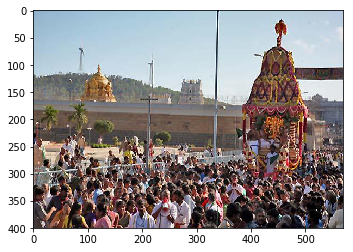

In [28]:
plt.imshow(img_no_normal[0].permute(1, 2, 0))

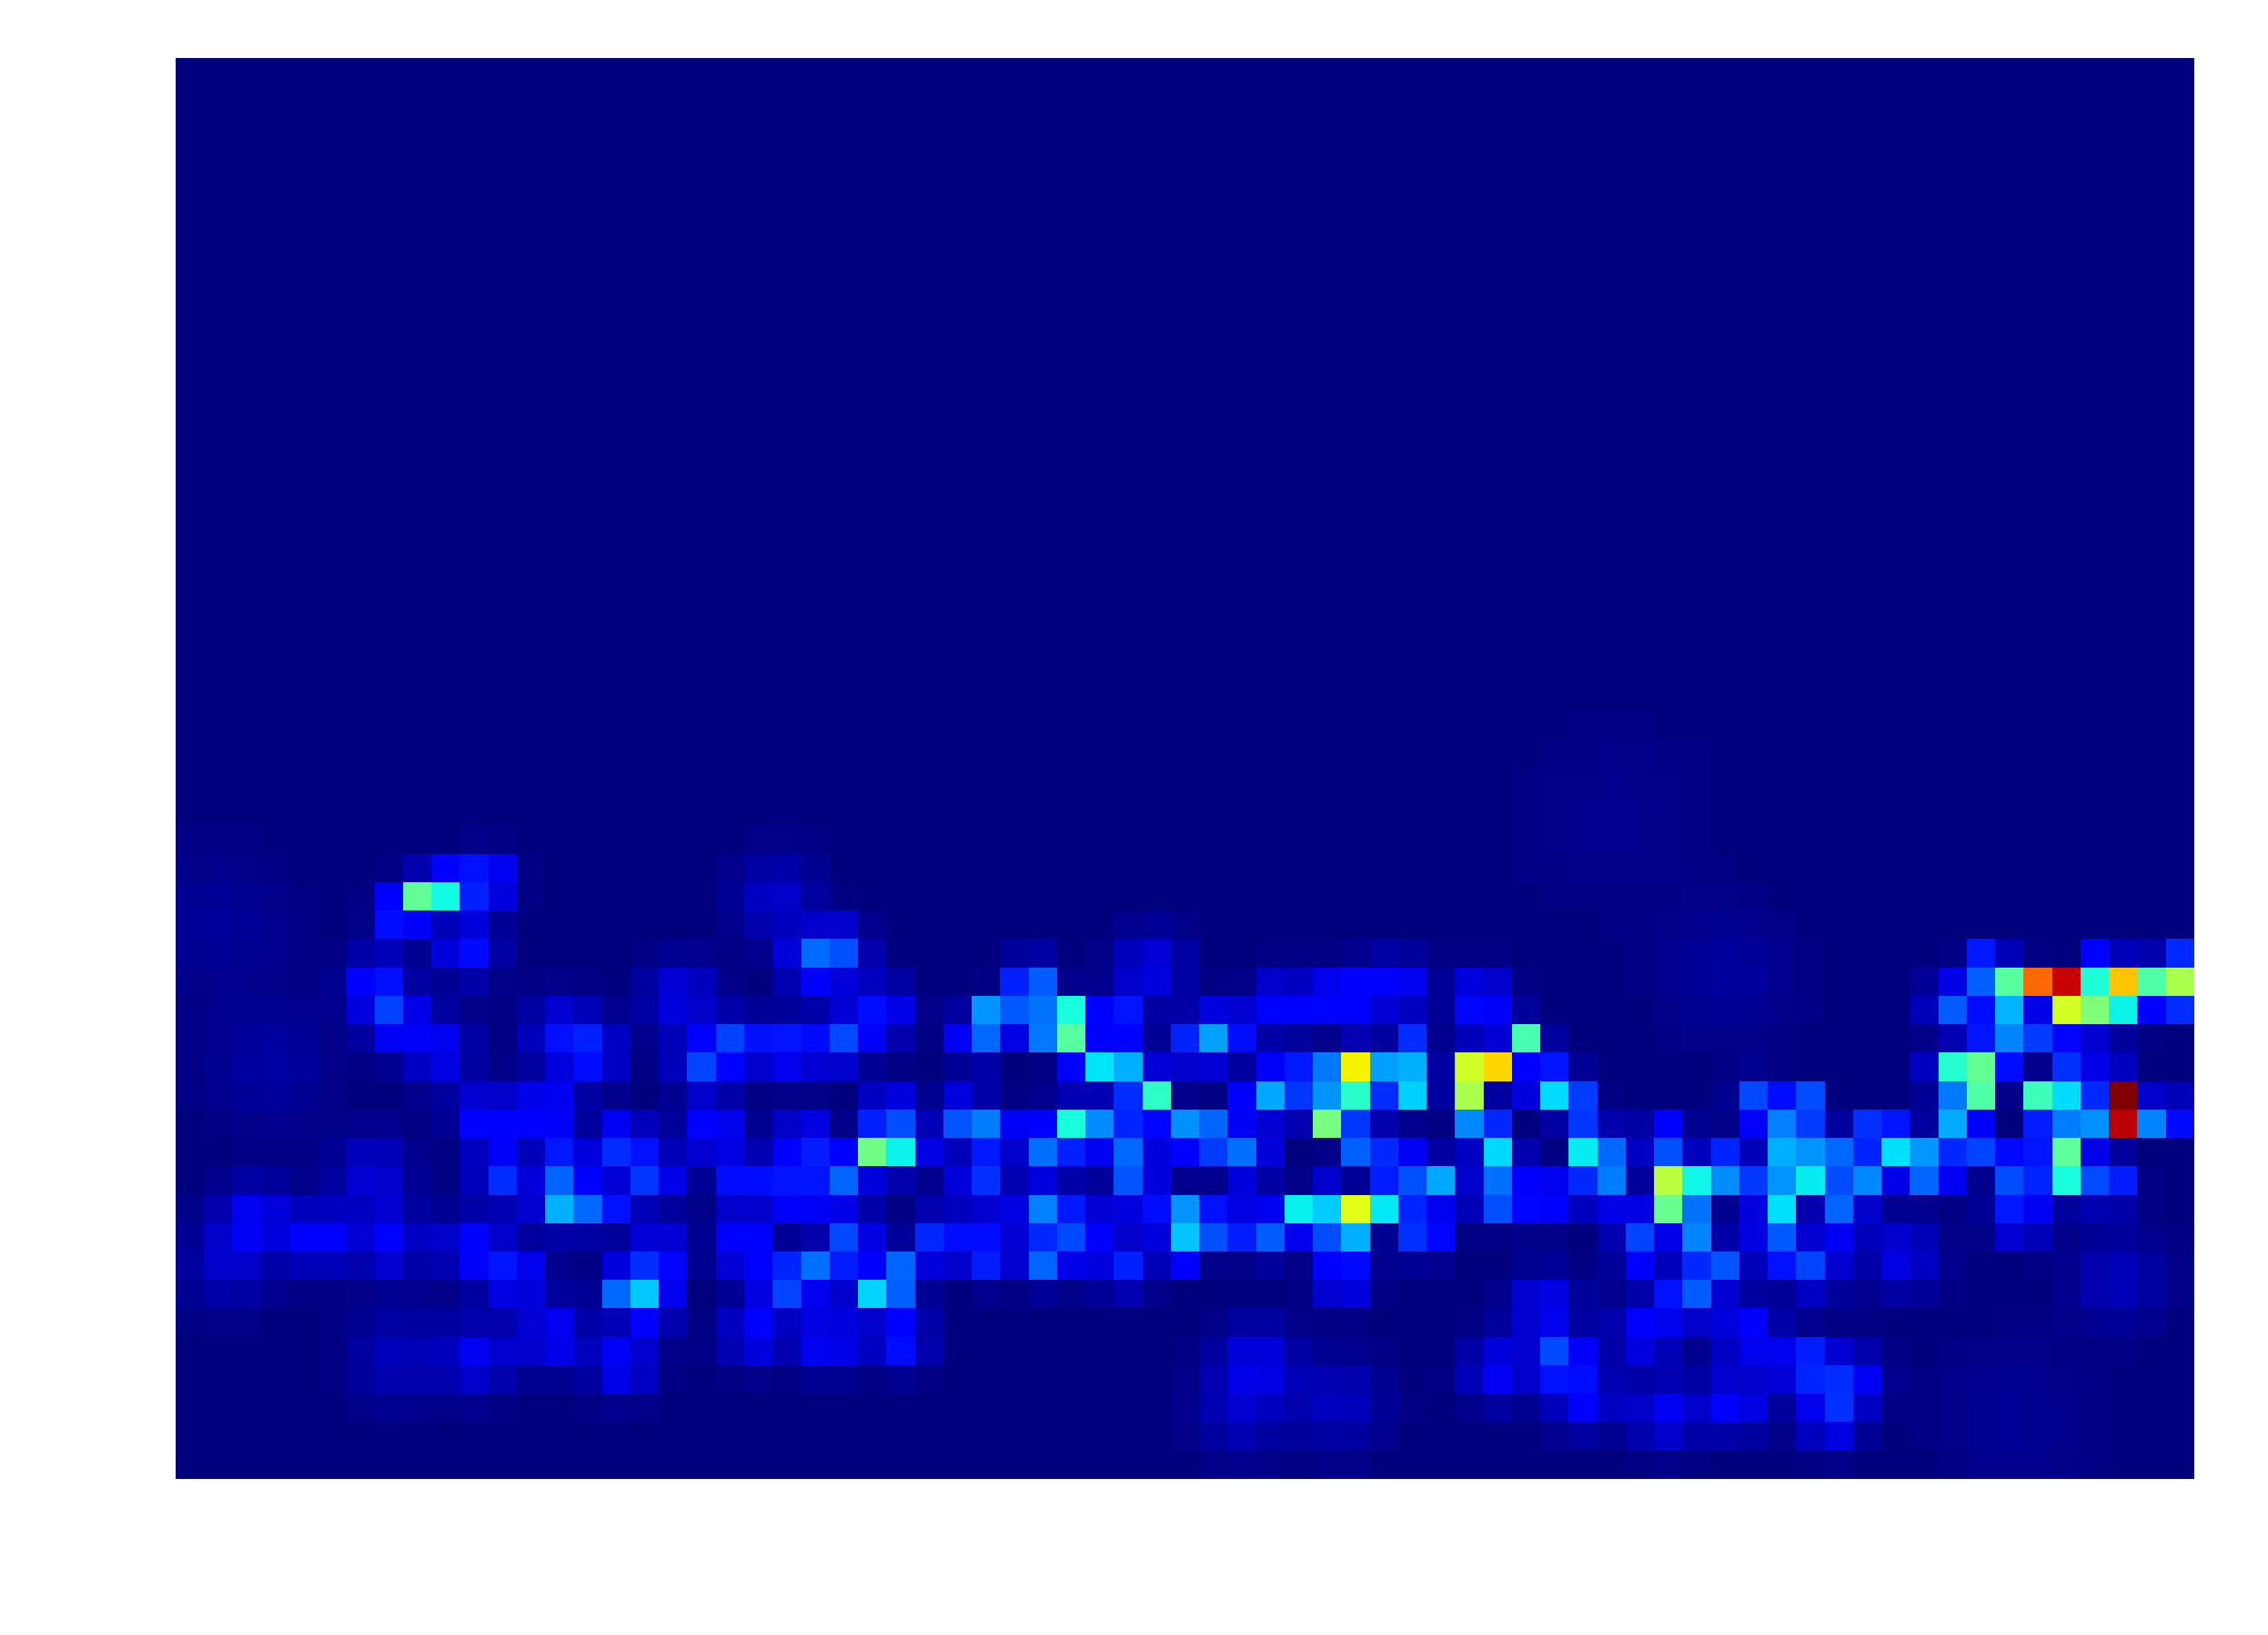

In [29]:
save_density_map(density2.cpu().detach().numpy()[0], "label.png")

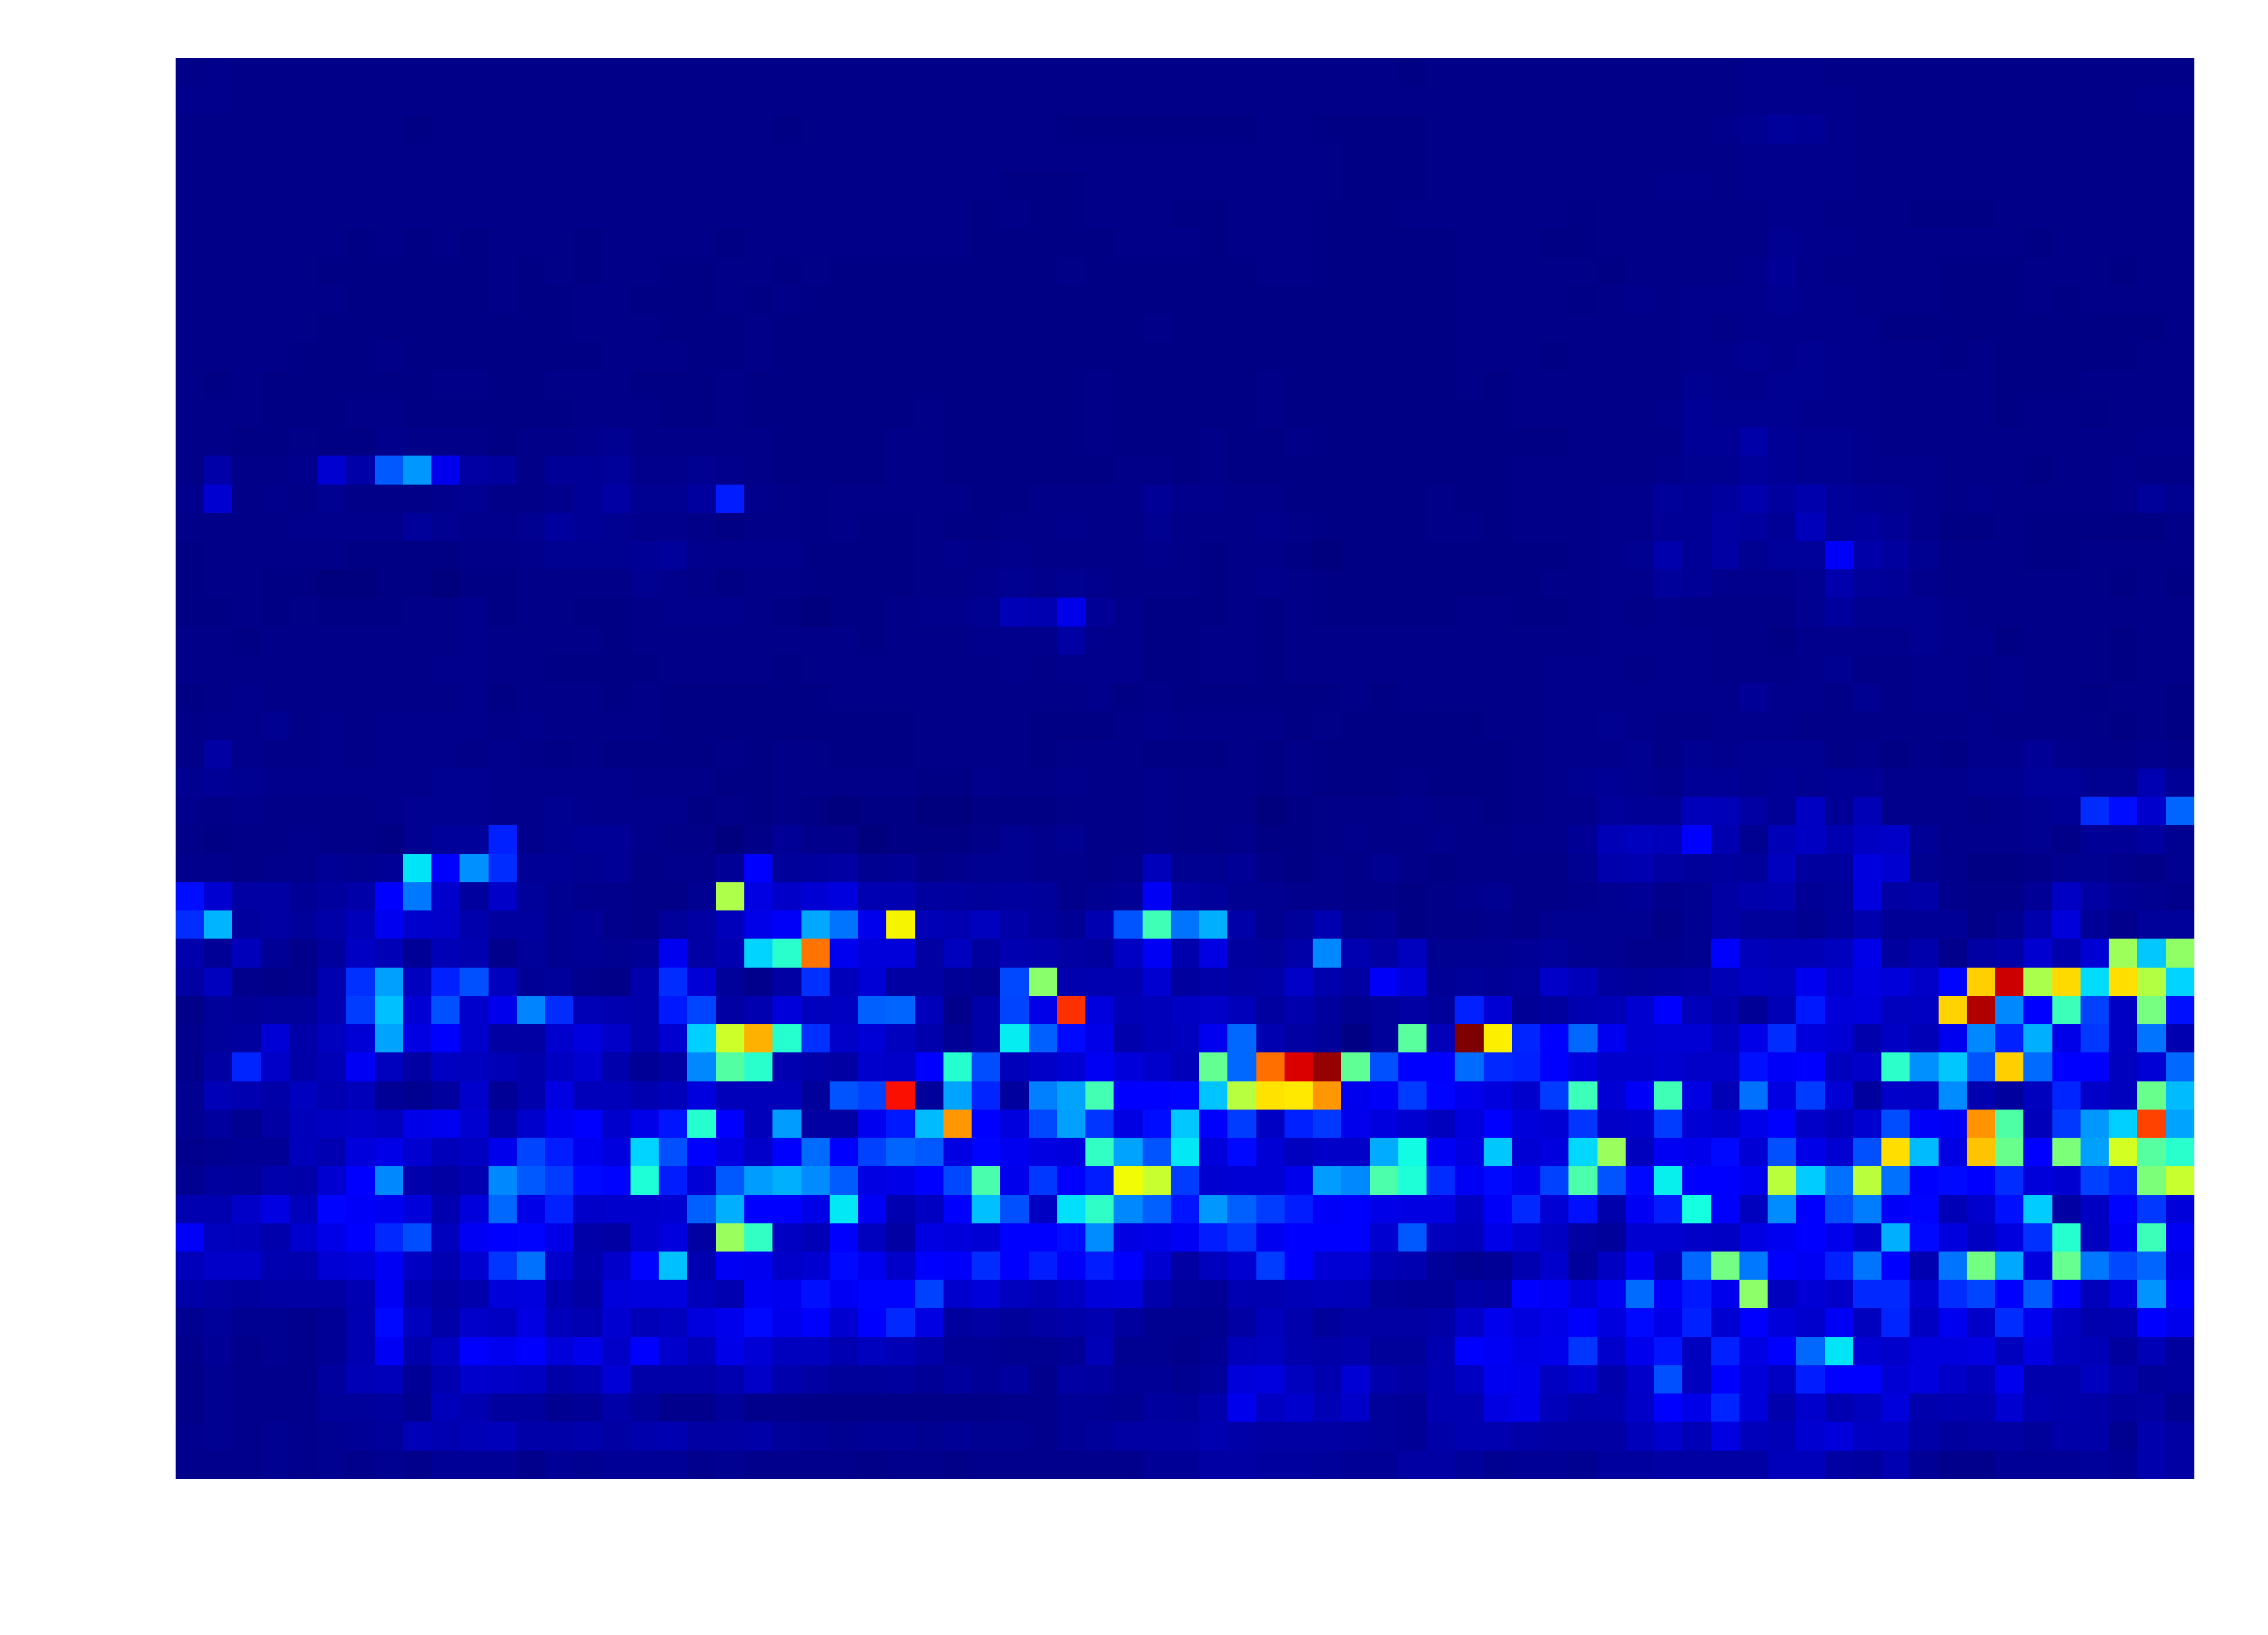

In [30]:
save_density_map(pred.cpu().detach().numpy()[0][0], "pred.png")